# 12. 직접 만들어보는 OCR

#### aaa.zip으로 압축하고 현재 폴더의 모든 것과 현재 폴더의 하위 폴더들도 모두 압축 예시
! zip aaa.zip -r ./*

#### aaa.zip 압축 해제 예시
$ unzip aaa.zip 

## 12.1) Dataset for OCR

In [1]:
%cd /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR
# !unzip -qq /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR/ocr.zip

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR


In [2]:
import os

path = os.getcwd()
os.chdir(path)

print(path)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR


## 12.2) Recognition model (1)

In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
!pip install lmdb

In [5]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getcwd()

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR/data/MJ/MJ_train


## 12.3) Recognition model (2) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


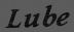

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


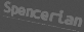

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


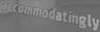

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


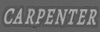

In [6]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요

## LMBD : B + 트리 인덱스를 기반으로 C 언어로 작성된 효율적이고 빠른 메모리 매핑 된 오픈 소스 데이터베이스라고 한다.

env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)
'''
max_readers : 최대 동시 읽기 트랜젝션... 트랜젝션이 뭐야? 병렬 구조?
readonly : 리돈이 뭔가했지만 리드 온리(읽기전용)
lock : 활성 중 사용금지 같은 거 같다. 파일 수정 중에 안열리는거 같은거
readahead : 미리읽기, 미리 안읽게 하면 램사용량을 줄일 수 있다고 한다.
meminit : 기억하다의 라틴어래요 글쎄... 버퍼를 디스크에 쓰기 전에 0으로 초기화하지 않는 경우 성능 향상... 이라는데 하나도 모르겠다.
'''


# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        # json 형식이라 -> 딕셔너리 -> key값을 먼저 가져오는듯... java는 잘 모르겠다.
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        # json 타입인 lmdb 형식 데이터 가져오는 법 기억해두기!

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [7]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        # 클래스에 기본적으로 사용되는 인자들 정의
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## 12.4) Recognition model (3) Encode

In [8]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []  # 레이블은 리스트
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]: # 연속된 두 문자가 같다면 (인덱스로 확인)
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [9]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 12.5) Recognition model (4) Build CRNN model

In [10]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [11]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2 #아마 연속된 레이블 표시를 위한 -, 공백을 위한 ' ' 두개를 더해준거같은데, 미리 추가하면 학습모델이랑 차원이 달라진다.
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## 12.6) Recognition model (5) Train & Inference

In [12]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [14]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=1,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

565/565 [==============================] - ETA: 0s - loss: 25.4527
Epoch 1: val_loss improved from inf to 23.89218, saving model to /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR/model_checkpoint.hdf5
565/565 [==============================] - 112s 158ms/step - loss: 25.4527 - val_loss: 23.8922


In [13]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [14]:
TARGET_CHARACTERS = TARGET_CHARACTERS + " "

이유는 모르겠지만 TARGET_CHARACTERS[-1]에 패딩되는 값이 들어간다.

초기에 이런부분을 추가하면 중간에 차원이 안맞던데...

아무튼 예측값 뒤에 9999999가 붙는 것을 막기위해

마지막에 " "을 추가해주었다

Result: 	 SLINKING                


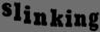

Result: 	 ALEPPO                 


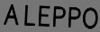

Result: 	 FWANDA                  


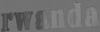

Result: 	 NATHANS                 


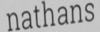

Result: 	 HALLE                  


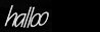

Result: 	 HURLS                   


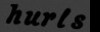

Result: 	 DOWNSIZE                


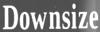

Result: 	 ROBOTIC                 


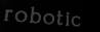

Result: 	 SLOPPY                 


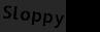

Result: 	 SHERMITE                


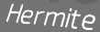

In [15]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]  #배치 사이즈에서 하나씩뗘오는거인듯?
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','') # 최종 결과값에서 -를 공백으로 대체
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)


# 여기서부터 실습

## 12.7) 프로젝트: End-to-End OCR

### 12.7.1) 라이브러리 버전 확인

In [16]:
!pip install --upgrade keras_ocr

In [17]:
!pip install --upgrade pillow

In [18]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.8.0
1.21.5
9.1.0
4.1.2
0.0.0


### 12.7.2) 데이터 확인


In [19]:
import os
%cd /content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR
HOME_DIR = os.getcwd()

print(HOME_DIR)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR
/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR


In [20]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [21]:
print(SAMPLE_IMG_PATH)

/content/drive/MyDrive/Colab_Notebooks/아이펠/GoingDeeper/OCR/data/sample.jpg


In [22]:
from PIL import Image, ImageDraw

In [23]:
img = Image.open(SAMPLE_IMG_PATH)
img.width

1200

In [24]:
img.height

900

In [25]:
def detect_text(img_path):
    img_pil = Image.open(img_path)    # 일단 이미지를 읽어온뒤에
    img_draw=ImageDraw.Draw(img_pil)  # 사각형 객체를 만들어준다
    result_img = img_pil              # img_pil은 자를꺼이므로 사본을 생성 (deepcopy 안해도 괜찮은건가?)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = img[tf.newaxis, :, :, :]    # batch_size axis를 추가
    det_result = detector.detect(img.numpy())
    ocr_result = det_result[0]
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.		
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
		
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red') #폴리곤은 retangle과는 다르게 다각형이어도 점들끼리 이을수 있다고 한다. fill을 쓰면 내부를 채울수도 있는듯
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5     #너무 딱맞으면 이상해서 보정해준듯
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

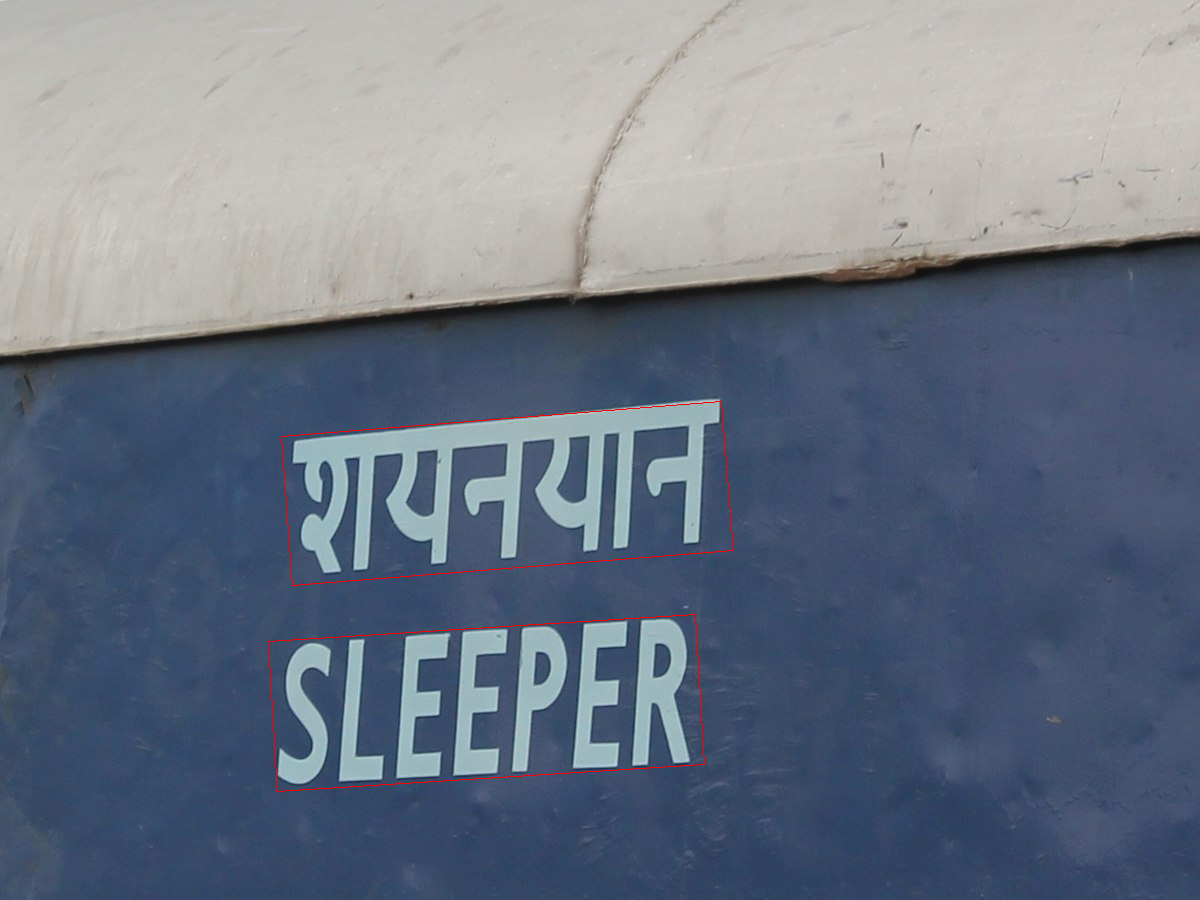

In [26]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

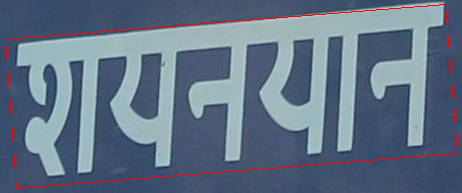

In [30]:
display(cropped_img[0])

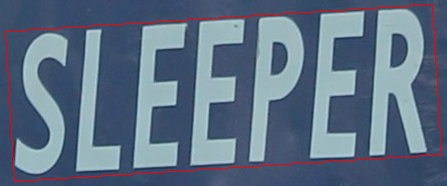

In [31]:
display(cropped_img[1])

In [34]:
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img = pil_img.resize(input_img_size)  # 이미지를 받아서 사이즈를 변경(여기선 중요치 않지만 크기가 다를 수 있으므로)
    np_img = np.array(pil_img)                # 넘파이 어레이로 만들어서
    np_img = np.transpose(np_img, (1, 0, 2))  # 모델 적용할 수 있도록 trasnpose 해주고
    np_img = np_img[np.newaxis, :, :, :]      # 마찬가지로 batch_size 차원을 axis=0에 추가
    output = model_pred.predict(np_img)       # 모델 적용 후
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','') # -는 대체
    print("Result:", result)                
    display(pil_img)

Result: SRAPRUIA                


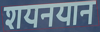

Result: SLEEPER                


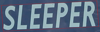

In [35]:
for _img in cropped_img:  #cropped_img는 이미지들 리스트(2개)이므로 하나씩 뽑아서 확인
    recognize_img(_img)

### 회고
여전히 class에 대한 이해가 부족해서 아쉬움이 있고

애시당초 좀 어려운 개념 특히 CV에서 많이 다루지 않는 RNN에 대한 이해가 부족한 것이 아쉽다.

대충 컨볼루션해서 detecting한 글자 이미지를 RNN을 돌리면서 

각각 ABCD 돌아가면서 판단하는거 같긴한데 정확하게 이해한 건 아닌 것 같다.

마찬가지로 PIL에 대한 기본이해도 좀 부족하다.

일단 어떻게 어떻게 꾸겨서 넘어가긴 했는데...

아마 OCR은 개인주제에서도 많이 쓸 것 같아서 잘 알아두면 좋을꺼 같다.